In [ ]:
from bisect import bisect_left

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def processed_data(df,network_basis_df,id_name):
    df_processed=df.copy()
    #------------------------------
    #include Epoch time
    sgt=list(df_processed['sgt'])
    epoch_time = [time.mktime((int(rectime[0:4]), int(rectime[5:7]), int(rectime[8:10]),int(rectime[11:13]) ,int(rectime[14:16]) ,int(rectime[17:19]), 0,0,0 ) ) for rectime in sgt]
    df_processed['TIMESTAMP']=epoch_time
    #sort the dataframe by time
    df_processed.sort_values(df_processed.columns[-1],inplace=True,ascending=True) 
    #------------------------------
    df_processed.drop(df_processed.loc[df_processed['TIMESTAMP']<1463500800].index, inplace=True)
    df_processed.drop(df_processed.loc[df_processed['TIMESTAMP']>1463587199].index, inplace=True)
    #Count number of access points
    mac=df_processed['mac']
    MAC=[x.split(',') for x in mac]
    #take only the 12 digit MAC address
    MAC_address=[]
    for m in MAC:
        mm=[x for x in m if (len(x)>15 and x!='MAC:ffffffffffff RSSI:-1')]
        if len(mm)!=0:
            mm=[x[4:16] for x in mm]
        MAC_address.append(mm)
        #print (mm)
    df_processed['MAC_address']=MAC_address

    #Aggregates all mac address found around every minute from start to end.
    temp_mac={}
    for index, row in df_processed.iterrows():
        timestamp=row['TIMESTAMP']
        t1=takeClosest(time_every_min, timestamp)
        #print (timestamp,t1)
        if not t1 in temp_mac:
            temp_mac[t1]=[]
        if (timestamp>=t1 and timestamp<t1+60):
            temp_mac[t1]+=row['MAC_address']
    for key,value in temp_mac.items():
        v=list(set(value)) #remove duplicates
        network_basis_df.at[key, id_name]=v

    return temp_mac



#### Create matrix of time vs ID with mac address as values. 
Contains mac address accumulated by each ID every minute of the day

In [ ]:
#--------------------------------------------
import time
import pandas as pd
import numpy as np
import glob, os
import networkx as nx
#Create dataframe with time split into every minute
time_every_min=np.linspace(1463500800,1463587200,1441)
time_every_min=[int(x) for x in time_every_min]
network_basis_df=pd.DataFrame(time_every_min, columns=['time_minute_interval'],dtype=object)
network_basis_df.set_index('time_minute_interval', inplace=True)

t0 = time.time()
path =r'//Users/Ajay/Documents/NSE2016 database/week3' # use your path to the folder containing all Id's
all_files = glob.glob(os.path.join(path, "*.csv")) 

it=0
for f in all_files:   
    id_name=f[-10:-4]
#     if id_name=='709911':
#         continue
    #---------------------
    df=pd.read_csv(f)
    if len(df)<1000:
        continue
    #---------------------
    initiate=[np.nan]*len(network_basis_df) #
    network_basis_df[id_name]=initiate
    network_basis_df[id_name]=network_basis_df[id_name].astype(object)
    temp_mac=processed_data(df,network_basis_df,id_name)
    print (id_name,len(df))
    it+=1
network_basis_df.to_csv('Copresence_Network_data.csv', sep=',') #save to csv    
print ('Elapsed time: ',time.time() - t0 )

#### Create copresence network with weights - number: Number of copresence events, volume: Total time spent in proximity

In [ ]:
import pandas as pd
df=pd.read_csv('Copresence_Network_data copy.csv')

In [ ]:
df.head()

In [ ]:
import itertools as it
import networkx as nx
import math as m
import numpy as np
mainlist=list(df.columns.values)
mainlist.remove('time_minute_interval')
G=nx.Graph()
for index, row in df.iterrows():
    for i1,i2 in it.combinations(mainlist, 2):
        val1=row[i1]
        val2=row[i2]
        if (type(val1)==float or type(val2)==float):
            continue
        val1=val1.split()
        val2=val2.split()
        if (len(val1)==0 or len(val2)==0):
            continue
#         if (type(val1)!=list or type(val2)!=list):
#             continue
#         if (np.isnan(val1) or np.isnan(val2)):
#             continue
        common_address=list(set(val1).intersection(val2))
        if len(common_address)==0:
            continue
        #print (i1,i2)
        if not G.has_edge(i1,i2):
            G.add_edge(i1,i2,copresence = [(row['time_minute_interval'],i1,i2,len(common_address))] )    # call reported by i1
        else:
            oldedge = G.get_edge_data(i1,i2)
            oldedge['copresence'].append((row['time_minute_interval'],i1,i2,len(common_address))) #Calls - all calls reported by i1 to i2
    print (index)

In [ ]:
#calculate proximity strength and number of copresence events.
for e in sorted(G.edges()):
    #print(e,G.get_edge_data(e[0],e[1]))
    i1 = e[0] ; i2 = e[1]
    listcopresence = G.get_edge_data(i1,i2)['copresence']  #collect contacts in the edge
    listcopresence=sorted(listcopresence, key=lambda x: x[0])
    proximity_strength=[x[3] for x in listcopresence]
    oldedge = G.get_edge_data(i1,i2)
    oldedge['number'] = len(listcopresence)
    oldedge['proximity_strength'] = float(sum(proximity_strength))/len(listcopresence)
    oldedge['copresence'] = listcopresence

In [ ]:
print (len(G.nodes()))

In [ ]:
for e in sorted(G.edges()):
    print(e,G.get_edge_data(e[0],e[1]))
    break

In [ ]:
#save the total graph
import time
# Save a gexf file readable by e.g. gephi
gcopy = nx.Graph()
for e in G.edges():
    tlist=[]
    prox_str = G.get_edge_data(e[0],e[1])['proximity_strength']
    nc = G.get_edge_data(e[0],e[1])['number']
    x=G.get_edge_data(e[0],e[1])['copresence']
    for i in x:
        tlist.append(i[0])
    t1=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(min(tlist)))
    try:
        t2=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(max(tlist)))
    except:
        t2=t1
    gcopy.add_edge(e[0],e[1], number = nc, proximity_strength = prox_str,copresence=str(x),start=t1,end=t2)
nx.write_gexf(gcopy,'Copresence_graph_total_data.gexf')
print (len(gcopy.nodes()),'nodes;',len(gcopy.edges()),'undirected edges')

In [ ]:
#save only important features. 
import time
# Save a gexf file readable by e.g. gephi
gcopy = nx.Graph()
for e in G.edges():
    tlist=[]
    prox_str = G.get_edge_data(e[0],e[1])['proximity_strength']
    nc = G.get_edge_data(e[0],e[1])['number']
    x=G.get_edge_data(e[0],e[1])['copresence']
    for i in x:
        tlist.append(i[0])
    t1=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(min(tlist)))
    try:
        t2=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(max(tlist)))
    except:
        t2=t1
    gcopy.add_edge(e[0],e[1], number = nc, proximity_strength = prox_str,start=t1,end=t2)
    
nx.write_gexf(gcopy,'Copresence_graph.gexf')
print (len(gcopy.nodes()),'nodes;',len(gcopy.edges()),'undirected edges')

In [54]:
G = nx.read_gexf('Copresence_graph_total_data.gexf')
print (len(G.edges()))
print (len(G.nodes()))

40617
915


In [4]:
print (G.get_edge_data('508665','604713'))

{'number': 519, 'proximity_strength': 9.296724470134874, 'copresence': "[(1463525160, '604713', '508665', 7), (1463525220, '604713', '508665', 12), (1463525280, '604713', '508665', 8), (1463525340, '604713', '508665', 10), (1463525400, '604713', '508665', 8), (1463525460, '604713', '508665', 7), (1463525520, '604713', '508665', 8), (1463525580, '604713', '508665', 7), (1463525640, '604713', '508665', 8), (1463525700, '604713', '508665', 7), (1463525760, '604713', '508665', 3), (1463525820, '604713', '508665', 6), (1463525880, '604713', '508665', 4), (1463525940, '604713', '508665', 4), (1463526000, '604713', '508665', 4), (1463526060, '604713', '508665', 9), (1463526120, '604713', '508665', 9), (1463526180, '604713', '508665', 5), (1463526240, '604713', '508665', 3), (1463526300, '604713', '508665', 5), (1463526360, '604713', '508665', 5), (1463526420, '604713', '508665', 8), (1463526480, '604713', '508665', 6), (1463526540, '604713', '508665', 8), (1463526600, '604713', '508665', 11),

<IPython.core.display.Javascript object>


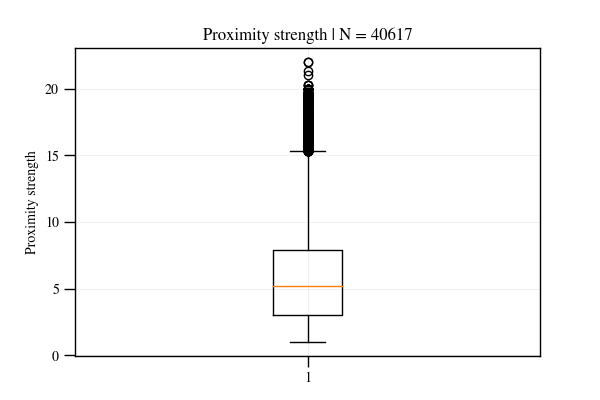

<IPython.core.display.Javascript object>


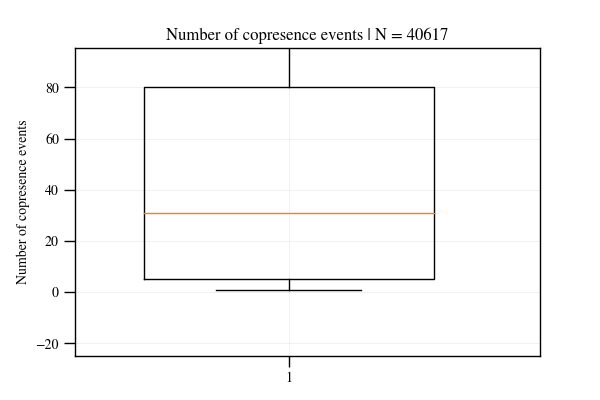

In [55]:
%matplotlib notebook
import ast
proximity_strength=[]
number_copresence=[]

for e in G.edges():
    proximity_strength.append(G.get_edge_data(e[0],e[1])['proximity_strength'])
    number_copresence.append(G.get_edge_data(e[0],e[1])['number'])
#     copresence=G.get_edge_data(e[0],e[1])['copresence']
#     copresence = ast.literal_eval(copresence)
#     if proximity_strength==1.0:
#         print (copresence)

#Boxplot 
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.boxplot(proximity_strength)
plt.title('Proximity strength | N = '+str(len(proximity_strength)))
plt.ylabel('Proximity strength')
plt.grid()
plt.savefig('boxplot_proximity_strength.png',dpi=200)
plt.show()
plt.figure(figsize=(6,4))
plt.boxplot(number_copresence)
plt.title('Number of copresence events | N = '+str(len(number_copresence)))
plt.ylabel('Number of copresence events')
plt.grid()
plt.savefig('boxplot_number_copresence.png',dpi=200)
plt.show()   

<IPython.core.display.Javascript object>


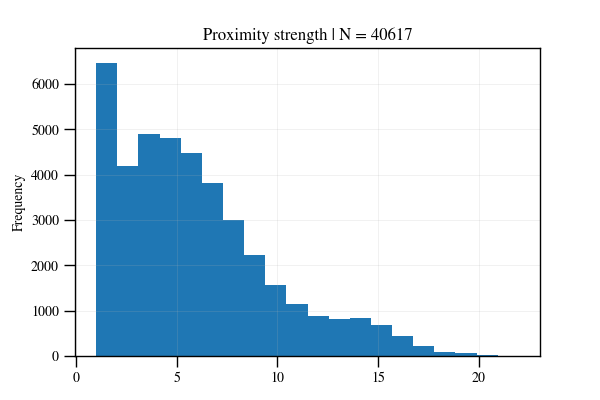

<IPython.core.display.Javascript object>


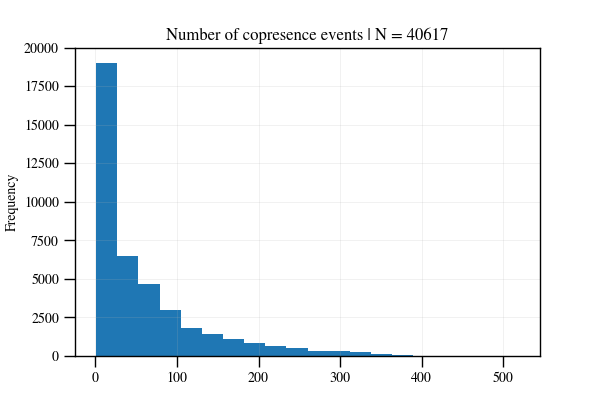

In [57]:
#histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(proximity_strength,bins=20)
plt.title('Proximity strength | N = '+str(len(proximity_strength)))
plt.ylabel('Frequency')
plt.grid()
plt.savefig('hist_proximity_strength.png',dpi=200)
plt.show()
plt.figure(figsize=(6,4))
plt.hist(number_copresence,bins=20)
plt.title('Number of copresence events | N = '+str(len(number_copresence)))
plt.ylabel('Frequency')
plt.grid()
plt.savefig('hist_number_copresence.png',dpi=200)
plt.show() 

<IPython.core.display.Javascript object>


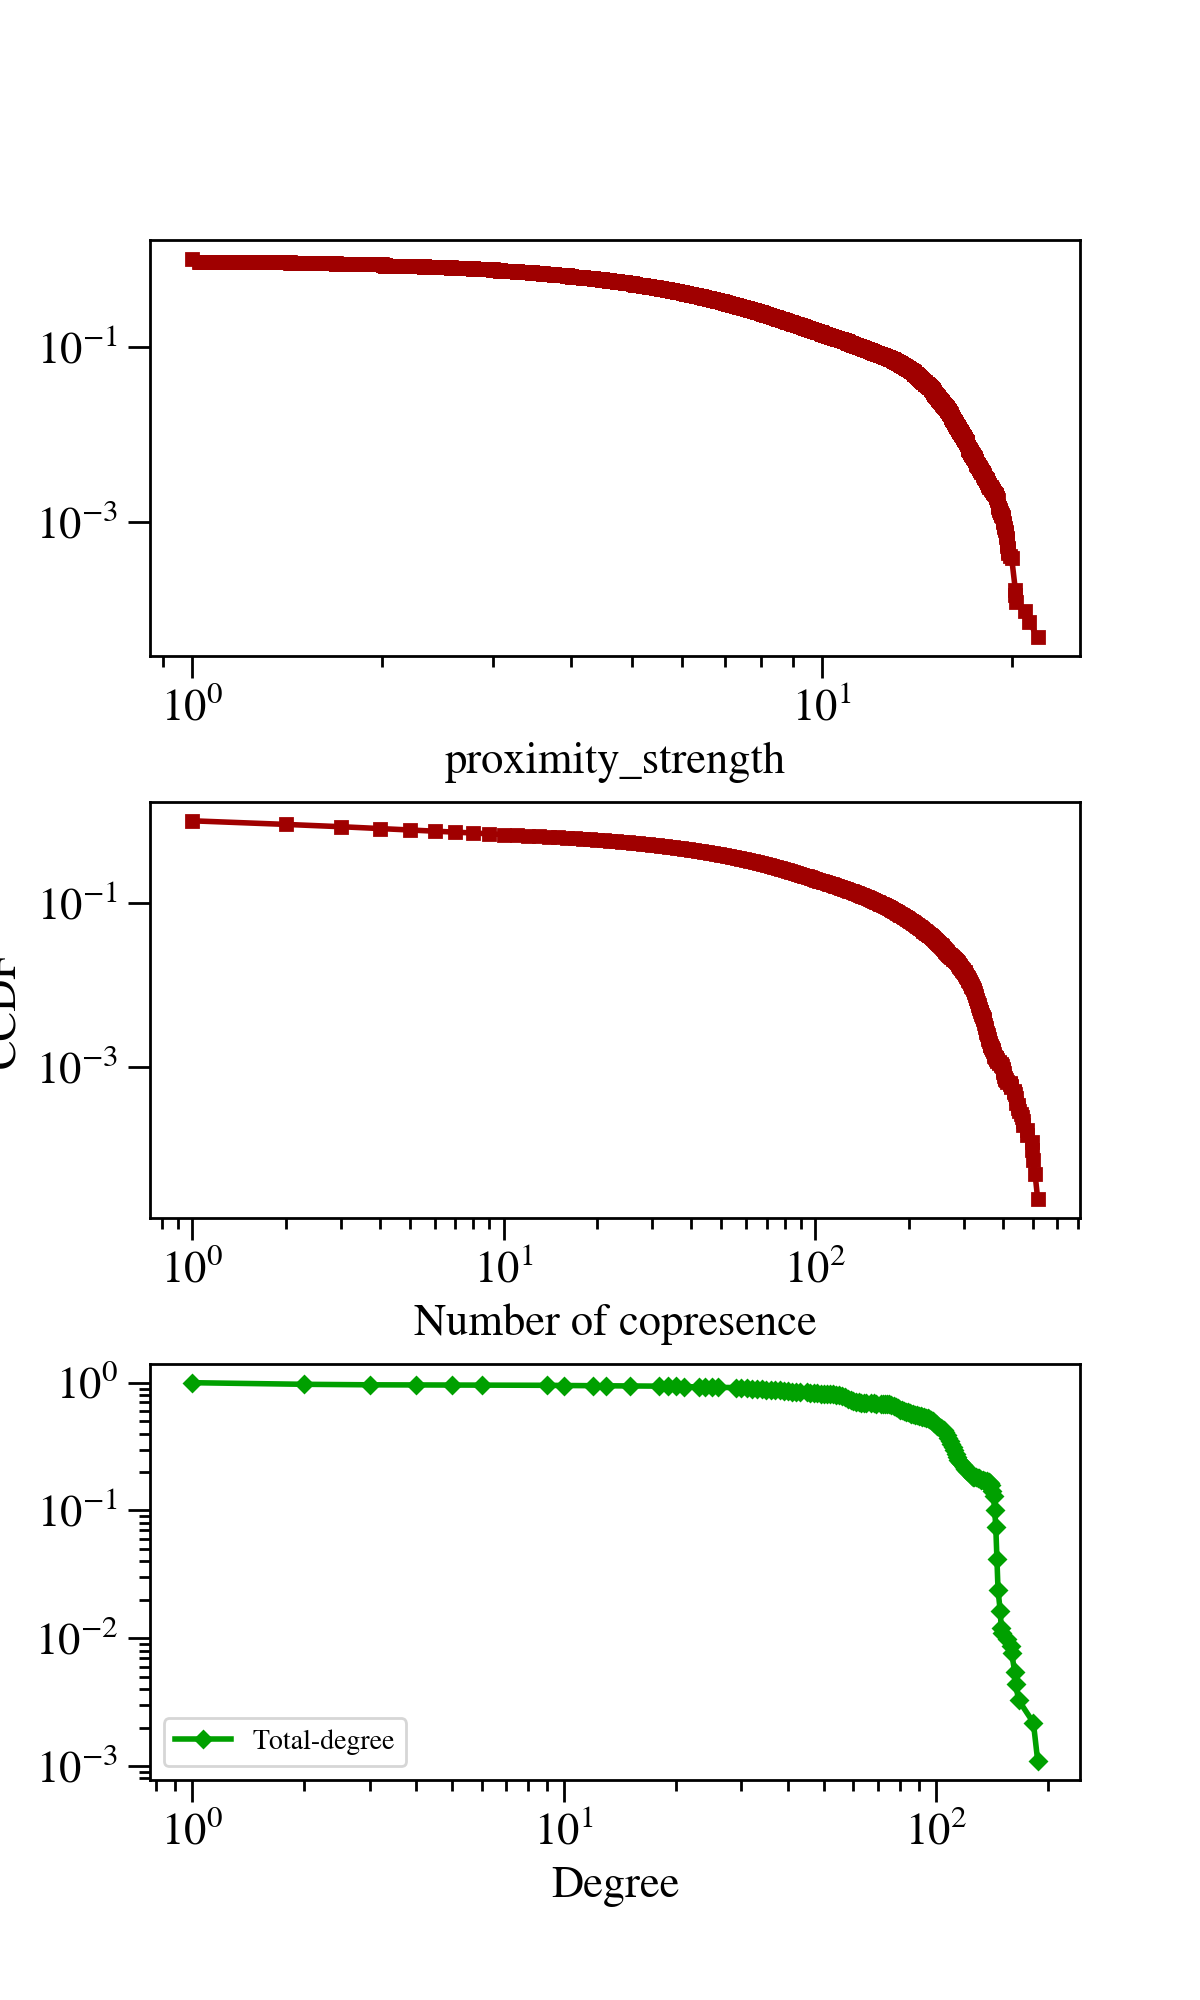

40617 number_of_copresence
40617 proximity_strength
40617 number_of_copresence
40617 proximity_strength
<class 'dict'>


In [53]:
#############################################
#CCDF - edge weights and node degrees
#############################################
from figformat import make_axs, ls_main, lp_main, ps_main, plt
def dist(g):
    cumul_cdf_num=[]
    cumul_cdf_vol=[]
            
    #--------------------------
    for (x,name) in zip(('number','proximity_strength'),('number_of_copresence','proximity_strength')):
        hist={}
        e_count=0
        for e in G.edges():            
            n = G.get_edge_data(e[0],e[1])[x]
            if n not in hist:
                hist[n] = 1.
            else:
                hist[n] += 1.
            e_count+=1
        cumul = 1.
        for n in sorted(hist.keys()):
            if name=='number_of_copresence':
                cumul_cdf_num.append([n,cumul])
            else:
                cumul_cdf_vol.append([n,cumul])
            cumul = cumul - hist[n]/e_count
        print (e_count,name)
    return cumul_cdf_num,cumul_cdf_vol  

def dist_deg(G):
    cumul_cdf_ktot=[]      
    #--------------------------
    x=G.degree()
    x=dict((xx, yy) for xx, yy in x)
    print (type(x))
    hist={}
    for node in G.nodes():
        if node not in x.keys():
            continue
        n = x[node]
        if n not in hist:
            hist[n] = 1.
        else:
            hist[n] += 1.
    cumul = 1.
    for n in sorted(hist.keys()):
        cumul_cdf_ktot.append([n,cumul])
        cumul = cumul - hist[n]/len(G.nodes())
    
    return cumul_cdf_ktot
    
    
    
def CDF_graph(G,sg,net1):
            #Attributes---------------------------    
    
    #fig, ax = plt.subplots(nrows=3, ncols=1, sharey=True,figsize=(6, 10))
    fig, ax = make_axs()
    #volume
    cdf_num_sim,cdf_vol_sim=dist(G)
    x=[a[0] for a in cdf_vol_sim]
    y=[a[1] for a in cdf_vol_sim]
    ax[0].loglog(x,y,**lp_main[0])
    ax[0].set_xlabel(r'proximity_strength',fontsize=16)
    ax[0].tick_params(labelsize=16)
    #number
    cdf_num_sim,cdf_vol_sim=dist(G)
    x=[a[0] for a in cdf_num_sim]
    y=[a[1] for a in cdf_num_sim]
    ax[1].loglog(x,y,**lp_main[0])
    ax[1].set_xlabel(r'Number of copresence',fontsize=16)
    ax[1].tick_params(labelsize=16)
#     #In-degree
#     kin,kout,ktot=dist_deg(G)
#     x=[a[0] for a in kin]
#     y=[a[1] for a in kin]
#     ax[2].loglog(x,y,label=r'In-degree',**lp_main[0])
# #    #out-degree
#     x=[a[0] for a in kout]
#     y=[a[1] for a in kout]
#     ax[2].loglog(x,y,label=r'Out-degree',**lp_main[1])
    #tot-degree
    ktot=dist_deg(G)
    x=[a[0] for a in ktot]
    y=[a[1] for a in ktot]
    ax[2].loglog(x,y,label=r'Total-degree',**lp_main[2])
    ax[2].set_xlabel(r'Degree',fontsize=16)
    ax[2].tick_params(labelsize=16)
    
#    plt.title('CCDF- weights for links with matching attributes '+net+' '+sg)
    ax[1].set_ylabel(r'CCDF',fontsize=16)
    for i in range(0,3):
        ax[i].spines['top'].set_visible(True)
        ax[i].spines['right'].set_visible(True)
    fig.subplots_adjust(hspace=.35)
    #ax[0].legend(loc='best')
    #ax[1].legend(loc='best')
    ax[2].legend(loc='best')
    fig.save('CCDF - weights '+net1+sg)

CDF_graph(G,'Freshmen','Copresence')

In [50]:
x=G.degree()
print (x)

[('709640', 160), ('709395', 122), ('709613', 100), ('402962', 100), ('403895', 103), ('709447', 110), ('709635', 116), ('709425', 102), ('709625', 147), ('702434', 108), ('709438', 107), ('709598', 137), ('403087', 140), ('509350', 122), ('403047', 106), ('402817', 101), ('403089', 120), ('508709', 115), ('709608', 101), ('709624', 109), ('402841', 145), ('709574', 107), ('508775', 102), ('403033', 104), ('403094', 99), ('403068', 101), ('709517', 131), ('508666', 109), ('709458', 116), ('402949', 141), ('508708', 99), ('402888', 140), ('709582', 101), ('709586', 103), ('709418', 118), ('709403', 108), ('702350', 110), ('709924', 110), ('402797', 114), ('508798', 116), ('709416', 113), ('509043', 131), ('403040', 113), ('509145', 109), ('709911', 94), ('508321', 105), ('508518', 115), ('402839', 117), ('512426', 137), ('402966', 123), ('403005', 96), ('709577', 110), ('403022', 149), ('709411', 124), ('402893', 124), ('402361', 124), ('402362', 160), ('709472', 140), ('709470', 132), 

In [17]:
#Count the occurences of each mac address
import pandas as pd
df=pd.read_csv('Copresence_Network_data copy.csv')
all_mac_address=[]
for c in df:
    if c=='time_minute_interval':
        continue
    lis=df[c]
    for i in lis:
        if type(i)==float:
            continue
        if len(i)==0:
            continue
        i = ast.literal_eval(i)
        all_mac_address+=i
        
from collections import Counter
x=Counter(all_mac_address)
sorted_x = sorted(x.items(), key=lambda kv: kv[0])#,reverse = True)

### Properties of Copresence Network

In [2]:
import networkx as nx
G = nx.read_gexf('Copresence_graph_total_data.gexf')

In [4]:
#(1463558400, '604713', '508665', 3)]
import ast

dic={}
for e in G.edges():
    copresence=G.get_edge_data(e[0],e[1])['copresence']
    copresence = ast.literal_eval(copresence)
    for c in copresence:
        if c[0] not in dic:
            dic[c[0]]=0
        dic[c[0]]+=1


<IPython.core.display.Javascript object>


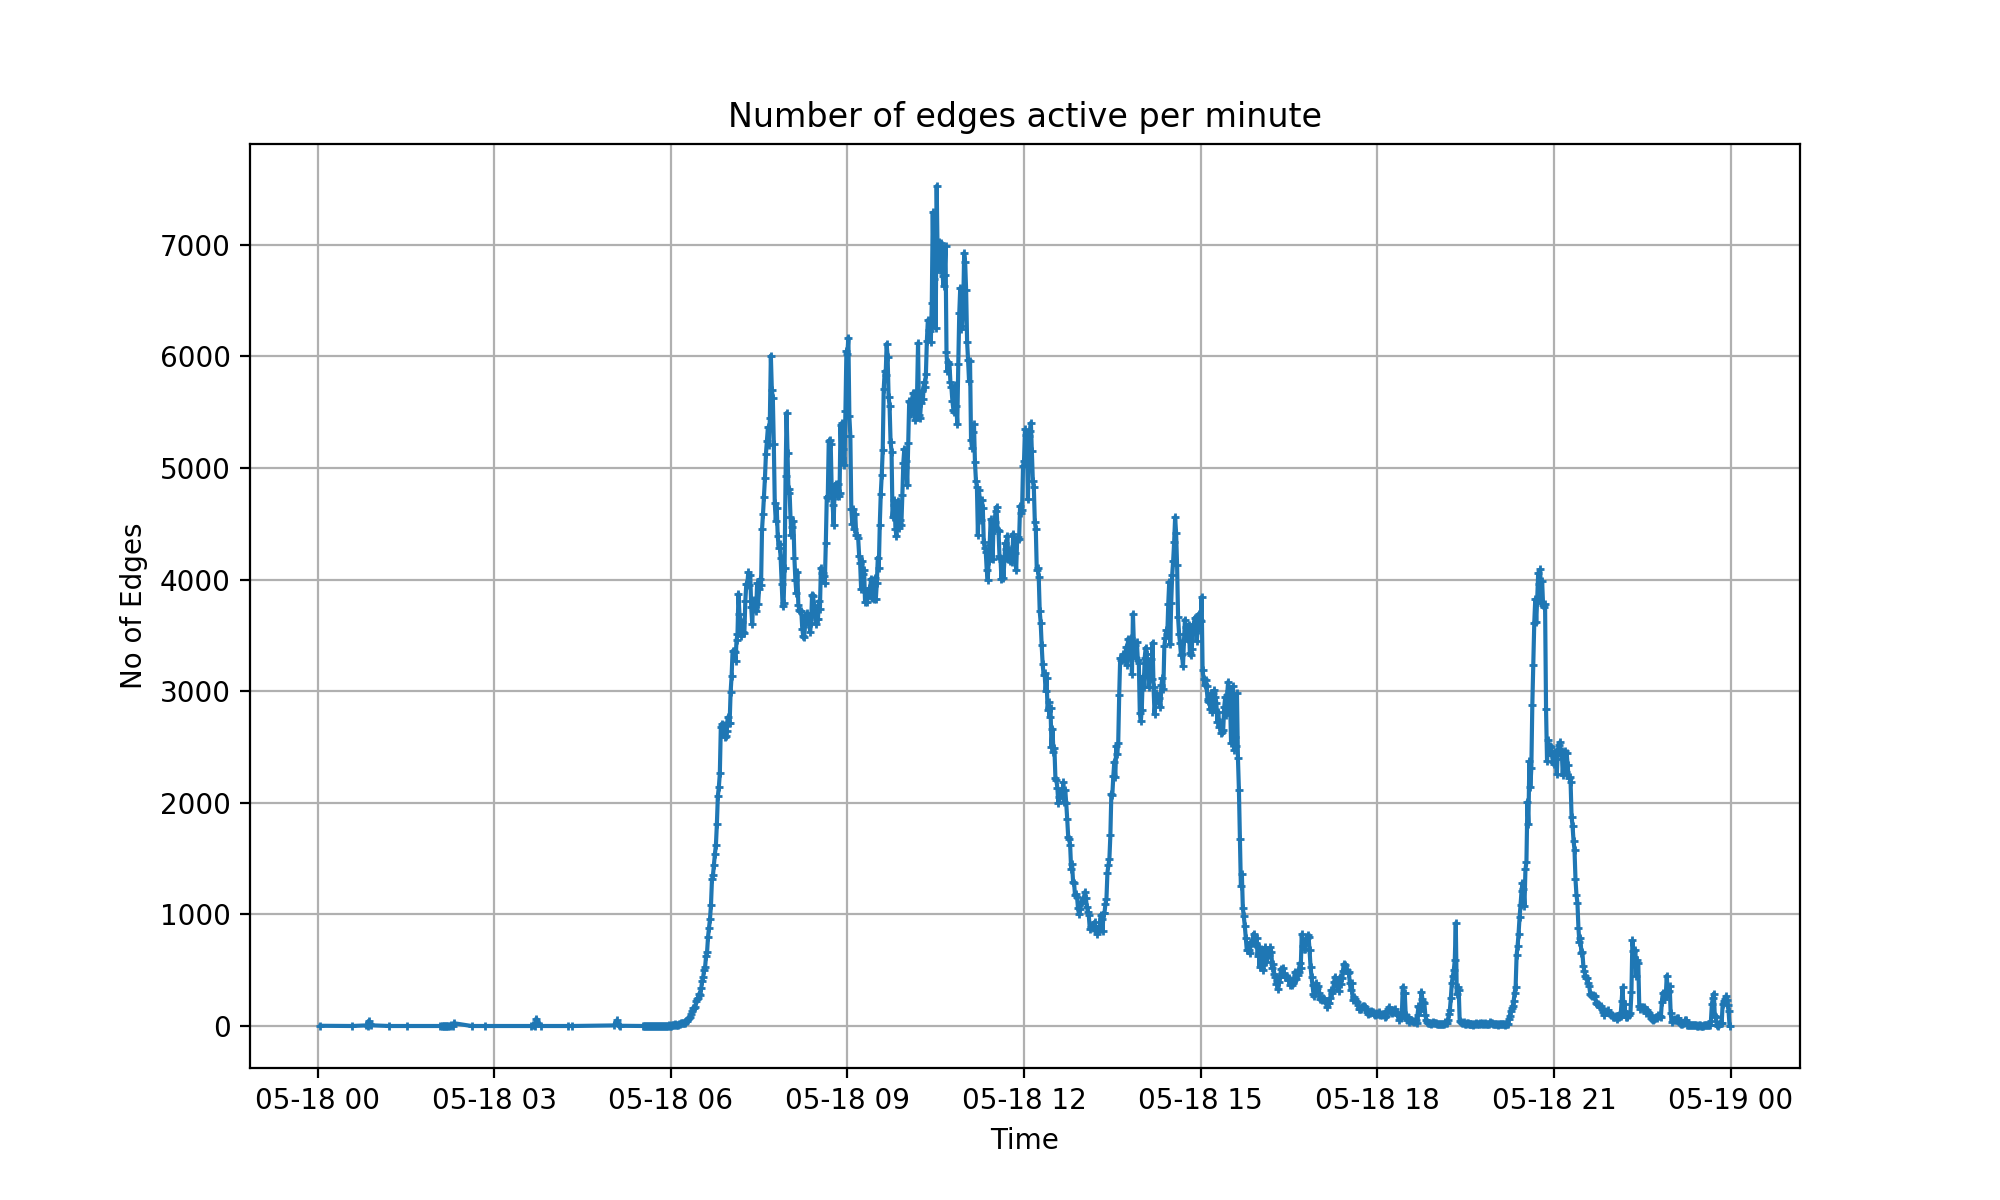

In [31]:
import datetime
import seaborn as sns
time=[]
No_of_edges=[]
for key, value in sorted(dic.items()):
    time.append(datetime.datetime.fromtimestamp(key))
    No_of_edges.append(value)
    
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,6))
plt.plot(time,No_of_edges,'-+',markersize=3)
plt.title('Number of edges active per minute')
plt.xlabel('Time')
plt.ylabel('No of Edges')
plt.grid()
plt.savefig('Number of edges active per minute.png',dpi=200)
plt.show()

In [ ]:
G = nx.MultiGraph()
for index, row in network_basis_df.iterrows():
    temp_edges=[]
    for ind1,val1 in row.iteritems():
        for ind2,val2 in row.iteritems():
            if ind1==ind2:
                continue
            if (type(val1)!=list or type(val2)!=list):
                #print(type(val1))
                continue
            if (len(val1)==0 or len(val2)==0):
                continue
            cm=list(set(val1).intersection(val2))
            if len(cm)!=0:
                s=(ind1,ind2,index)
                if not s in temp_edges:
                    #G.edges[ind1, ind2, index]['weight'] = len(cm)
                    G.add_edge(ind1,ind2,weight=len(cm),time=index,AP=cm)
                    temp_edges.append((ind2,ind1,index))
# g.add_edge(e[0],e[1], number = nc, volume = totdur,start=t1,end=t2)
# t1=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(t1))
# t2=time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime(t2))
# g.add_edge(e[0],e[1], number = nc, volume = totdur,start=t1,end=t2)

In [ ]:
G = nx.MultiGraph()
#G.add_edge([1,2,{'time':12},{'weight':12}])
G.add_edge(1,2,weight=12,time=12)
G.add_edge(1,2,weight=5,time=13)

In [ ]:
G.get_edge_data('709640', '709395')

In [ ]:
print (len(G.nodes(data=True)))
for e in G.edges():
    
    print(e,G.get_edge_data(e[0],e[1]))
    

In [ ]:
nx.write_gexf(G,'Colocation_graph.gexf')

In [ ]:
G.add_edge(1, 2)
G.edges[1, 2, 1330]['weight'] = 4